# **PARALLEL CHESS ENGINE**

## **THƯ VIỆN**

In [12]:
import warnings
warnings.filterwarnings('ignore')

from ChessEngine import *
from numba.cuda.cudadrv.driver import CudaAPIError
import matplotlib.pyplot as plt
import pandas as pd
import time
import math

## **THÔNG TIN NHÓM**

| Họ và tên sinh viên |   MSSV   |
|---------------------|----------|
| Võ Văn Hiếu         | 19120511 |
| Huỳnh Đức Huy       | 19120526 |
| Vương Thế Khang     | 19120539 |

## **ĐỀ TÀI**

Đề tài của nhóm là **song song hóa thuật toán tìm kiếm minimax trong cờ vua**.

Nhóm đã cài đặt 3 phiên bản: *1 phiên bản tuần tự* và *2 phiên bản song song*.

Để đánh giá các phiên bản của thuật toán, ta đánh giá:
- Thời gian thực thi của phiên bản
- Số lượng node của cây minimax được duyệt qua
- Kết quả tìm được (lấy kết quả của phiên bản tuần tự làm chuẩn)

## **BIỂU DIỄN MỘT VÁN CỜ VUA**

### **QUÂN CỜ VÀ BÀN CỜ**

**Quân cờ**

Trong cờ vua, có:
- *2 bên* (trắng và đen)
- *6 loại quân cờ* (vua, tốt, mã, tượng, xe, hậu)

Để biểu diễn một quân cờ, ta sử dụng một số nguyên 8 bit, trong đó:
- 3 bit đầu biểu diễn loại quân cờ

| Loại quân cờ | 3 bit biểu diễn |
|--------------|-----------------|
| Trống        | `000`           |
| Vua          | `001`           |
| Tốt          | `010`           |
| Mã           | `011`           |
| Tượng        | `100`           |
| Xe           | `101`           |
| Hậu          | `110`           |

- Bit thứ 4 biểu diễn bên mà quân cờ đó thuộc về:
    - `0`: đen
    - `1`: trắng

**Bàn cờ**

Trên CPU và GPU, một bàn cờ được biểu diễn bằng một mảng 64 số nguyên 8 bit, mỗi số nguyên biểu diễn một quân cờ trên một ô của bàn cờ.

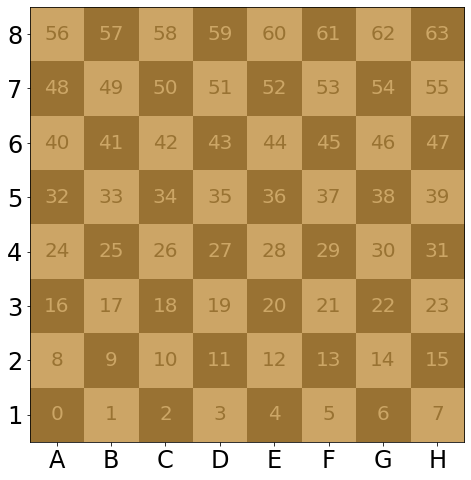

In [20]:
board = np.ones((8, 8)) - np.indices((8, 8)).sum(axis=0) % 2

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.tick_params(axis = 'both', labelsize = 24)
ax.set_xticks(np.arange(8))
ax.set_xticklabels([ 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H' ])
ax.set_yticks(np.arange(8))
ax.set_yticklabels([ '8', '7', '6', '5', '4', '3', '2', '1' ])

ax.imshow(board, cmap=ListedColormap([[0.6, 0.45, 0.2, 1.0], [0.8, 0.65, 0.4, 1.0]]))

for i in range(64):
    r = i // 8
    c = i % 8

    color = [0.6, 0.45, 0.2, 1.0] if ((r + c) % 2 != 0) else [0.8, 0.65, 0.4, 1.0]
    ax.text(c, 7 - r, str(i), fontsize = 20, color = color, horizontalalignment = 'center', verticalalignment = 'center')

### **QUYỀN NHẬP THÀNH**

Trong cờ vua, vua có thể nhập thành nếu như có quyền. Ban đầu, mỗi vua đều có thể nhập thành 2 bên (bên vua, bên hậu) nếu như đáp ứng được điều kiện nhập thành.

Trên CPU, ta sử dụng 4 biến bool để biểu diễn quyền nhập thành, lần lượt là:
- Quyền vua trắng nhập thành bên vua
- Quyền vua trắng nhập thành bên hậu
- Quyền vua đen nhập thành bên vua
- Quyền vua đen nhập thành bên hậu

Trên GPU, để hạn chế kích thước dữ liệu khi sao chép dữ liệu giữa CPU và GPU, ta sử dụng 1 số nguyên 8 bit, với 4 bit đầu mỗi bit tương ứng với 1 biến bool trên CPU.

### **TỐT QUA ĐƯỜNG**

Tại vị trí mặc định ban đầu, quân tốt có thể bước 1 hoặc 2 bước. Khi bước 2 bước, quân tốt đó trở thành *tốt qua đường* trong vòng 1 lượt. Khi đó, bên đối phương có thể *bắt tốt qua đường*.

Trên CPU và GPU, ta dùng 1 số nguyên trong [-1, 64) để biểu diễn tốt qua đường hiện tại của ván cờ, trong đó:
- -1 nghĩa là tại thời điểm đó, không có tốt qua đường
- [0, 64) nghĩa là số nguyên đó đánh dấu vị trí mà tốt qua đường vừa đi qua

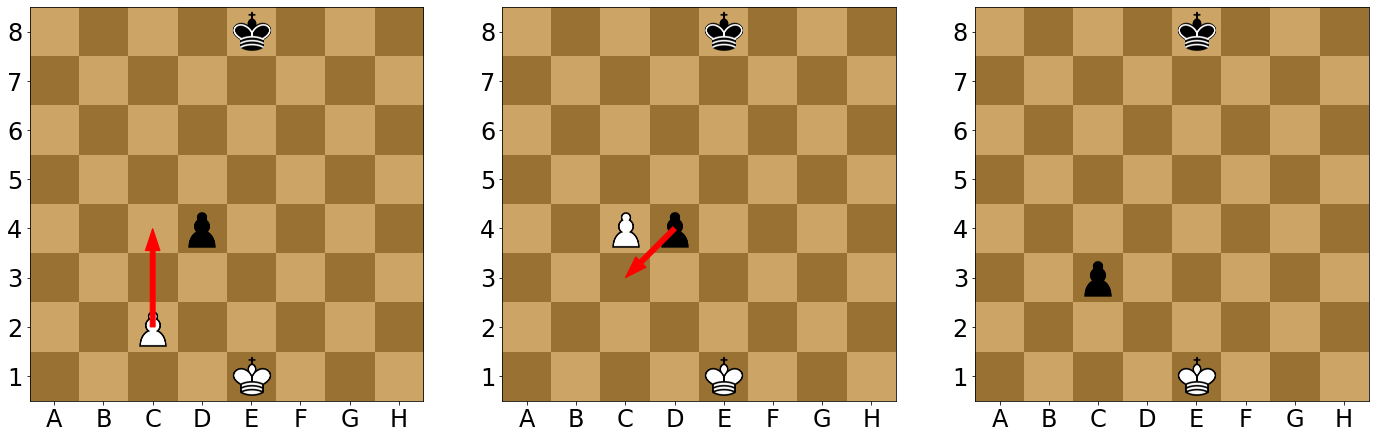

In [26]:
fig, ax = plt.subplots(1, 3, figsize = (24, 8))

game = ChessGame('4k3/8/8/8/3p4/8/2P5/4K3 w - - 0 1')

move1 = Move(10, 26)
game.plot(ax = ax[0], moves = [move1])
game.move(move1)

move2 = Move(27, 18, en_passant_target = 18)
game.plot(ax = ax[1], moves = [move2])
game.move(move2)

game.plot(ax = ax[2])

### **LUẬT HÒA 50 NƯỚC**

Trong một ván cờ, nếu như mỗi bên đi được 50 nước (tổng cộng 100 nước đi liên tiếp) mà không có tiến triển gì thì sẽ được xem là hòa cờ.

Một nước đi được xem là có tiến triển nếu như trong nước đi đó:
- Bắt được quân cờ của đối phương
- Là nước đi của tốt

Trong một ván cờ có một chỉ số gọi là *halfmove*. Khi một nước đi được xem là có tiến triển được thực hiện, halfmove được gán về 0. Ngược lại, nếu như nước đi không có tiến triển được thực hiện, halfmove tăng lên 1. Khi halmove đạt giá trị 100 thì ván cờ được xem là hòa.

Trên CPU và GPU, halfmove được biểu diễn là một số nguyên.

### **CHUẨN FEN**

Chuẩn FEN, hay Forsyth-Edwards Notation, là một phương pháp biểu diễn một ván cờ tại một thời điểm thông qua một chuỗi ASCII.

Trong đồ án này, FEN là phương tiện để khởi tạo một bàn cờ.

## **ĐÁNH GIÁ BÀN CỜ**

## **THUẬT TOÁN TÌM KIẾM MINIMAX**

### **PHIÊN BẢN TUẦN TỰ**

#### MINIMAX CƠ BẢN

```python
def possible_moves(chess_game): # Move generation function
    ...

def evaluate_board(chess_game): # Chessboard evaluation function
    ...

def sequencial_minimax(chess_game, search_depth):

    # If reach search limit, return the score of the current chessboard
    if search_depth == 0:
        return evaluate_board(chess_game)


    # Get all possible moves
    moves = possible_moves(chess_game)


    # If there is no possible move, it's either draw or checkmate
    if len(moves) == 0:
        return 0.0 if chess_game.draw() else -inf


    # Evaluate each possible move and find the best one
    result = -inf
    for move in moves:
        chess_game.move(move)
        evaluation = -sequencial_minimax(chess_game, search_depth - 1)
        chess_game.undo_move()

        result = max(result, evaluation)

    return result
```

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA

```python

def possible_moves(chess_game): # Move generation function
    ...

def evaluate_board(chess_game): # Chessboard evaluation function
    ...

def sequencial_minimax_alpha_beta(chess_game, search_depth, alpha = -inf, beta = inf):

    # If reach search limit, return the score of the current chessboard
    if search_depth == 0:
        return evaluate_board(chess_game)


    # Get all possible moves
    moves = possible_moves(chess_game)


    # If there is no possible move, it's either draw or checkmate
    if len(moves) == 0:
        return 0.0 if chess_game.draw() else -inf


    # Evaluate each possible move and find the best one
    for move in moves:
        chess_game.move(move)
        evaluation = -sequencial_minimax_alpha_beta(chess_game, search_depth - 1, -beta, -alpha)
        chess_game.undo_move()

        if evaluation >= beta:
            return beta

        alpha = max(alpha, evaluation)

    return alpha

```

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA VÀ SẮP XẾP NODE CON

```python

def possible_moves(chess_game): # Move generation function
    ...

def evaluate_board(chess_game): # Chessboard evaluation function
    ...

def sort_moves(moves): # Move sorting function
    ...

def sequencial_minimax_alpha_beta_move_sorting(chess_game, search_depth, alpha = -inf, beta = inf):

    # If reach search limit, return the score of the current chessboard
    if search_depth == 0:
        return evaluate_board(chess_game)


    # Get all possible moves and sort
    moves = possible_moves(chess_game)
    moves = sort_moves(moves)

    # If there is no possible move, it's either draw or checkmate
    if len(moves) == 0:
        return 0.0 if chess_game.draw() else -inf


    # Evaluate each possible move and find the best one
    for move in moves:
        chess_game.move(move)
        evaluation = -sequencial_minimax_alpha_beta_move_sorting(chess_game, search_depth - 1, -beta, -alpha)
        chess_game.undo_move()

        if evaluation >= beta:
            return beta

        alpha = max(alpha, evaluation)

    return alpha

```

### **PHIÊN BẢN SONG SONG 1**

#### MINIMAX CƠ BẢN

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA

#### MINIMAX VỚI CẮT TỈA ALPHA - BETA VÀ SẮP XẾP NODE CON

### **PHIÊN BẢN SONG SONG 2**